In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import spotipy
import spotipy.util as util
import re

from spotipy.oauth2 import SpotifyClientCredentials
from torch.utils import data
from torch.autograd import Variable


In [20]:
class CustomDataset(data.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [21]:
dataset = pd.read_csv(r'net2input.csv')
dataset_training = dataset.truncate(after=48000).reset_index(drop=True)
training_outputs = dataset_training['move_class'].to_numpy()
training_inputs = dataset_training.drop(columns=['move_class']).to_numpy()

training_data = CustomDataset(torch.LongTensor(training_inputs), torch.LongTensor(training_outputs))

dataset_testing = dataset.truncate(before=48001).reset_index(drop=True)
testing_outputs = dataset_testing['move_class'].to_numpy()
testing_inputs = dataset_testing.drop(columns=['move_class']).to_numpy()

testing_data = CustomDataset(torch.LongTensor(testing_inputs), torch.LongTensor(testing_outputs))


train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size = 1000, shuffle = True)
testing_loader = torch.utils.data.DataLoader(dataset=testing_data, batch_size = 1000, shuffle = True)
print(len(train_loader))
print(len(testing_loader))

input_size = 8
output_size = dataset["move_class"].nunique()
print(output_size)
hidden_size = 2


49
13
15


In [22]:
dataset

,index,start_time,duration,section,tempo,danceability,energy,valence,move_class
0,0,8.64248,0.53227,0,113.255,0.935,0.526,0.854,0
1,1,9.17475,0.53417,0,113.255,0.935,0.526,0.854,0
2,2,9.70893,0.53276,0,113.255,0.935,0.526,0.854,0
3,3,10.24169,0.53135,0,113.255,0.935,0.526,0.854,0
4,4,10.77303,0.52898,0,113.255,0.935,0.526,0.854,0
...,...,...,...,...,...,...,...,...,...
60894,485,206.29409,0.41231,7,144.041,0.687,0.514,0.494,3
60895,486,206.70641,0.41176,7,144.041,0.687,0.514,0.494,3
60896,487,207.11817,0.41164,7,144.041,0.687,0.514,0.494,3
60897,488,207.52981,0.41433,7,144.041,0.687,0.514,0.494,3


In [28]:
class Neural_Network(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hiddenSize, outputSize)
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out

    #def backward(self, X, y, o):
     #   self.o_error = y - o # error in output
      #  self.o_delta = self.o_error * self.sigmoidPrime(o) # derivative of sig to error
       # self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
        #self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
        #self.W1 += torch.matmul(torch.t(X), self.z2_delta)
        #self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)
    
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoidPrime(self, s):
        # derivative of sigmoid
        return s * (1 - s)

In [29]:
NN = Neural_Network(input_size, hidden_size, output_size)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(NN.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)

In [30]:
num_epochs = 200

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

NN = NN.float()
for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, batch in enumerate(train_loader):
        
        items = Variable(batch[0])
        classes = Variable(batch[1])
        
        NN.train()
        
        optimizer.zero_grad()
        outputs = NN(items.float())
        loss = criterion(outputs, classes)
        loss.backward()
        optimizer.step()
        
        train_total += classes.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()
        
        print("Epoch %d/%d, Iteration %d/%d"
                 %(epoch+1, num_epochs, i+1, len(dataset_training)//1000))
        print(loss)
        
    NN.eval()
        
    train_loss.append(loss.data)
        
    train_accuracy.append((100 * train_correct / train_total))
        
    test_items = torch.FloatTensor(testing_inputs)
    test_classes = torch.LongTensor(testing_outputs)
    outputs = NN(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.data)
    
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))


Epoch 1/200, Iteration 1/48
tensor(12.3647, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 2/48
tensor(2.7778, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 3/48
tensor(2.7764, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 4/48
tensor(2.8052, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 5/48
tensor(2.7670, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 6/48
tensor(2.7848, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 7/48
tensor(2.7826, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 8/48
tensor(2.7880, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 9/48
tensor(2.7887, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 10/48
tensor(2.7865, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 11/48
tensor(2.7786, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 12/48
tensor(2.7964, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 13/48
tensor(2.8089, grad_fn=<NllLossBackward>)
Epoch 1/200, Iteration 14/48
tensor(2.8015, grad_fn=<NllLossBackward>)
Epoch 1/200, I

Epoch 3/200, Iteration 25/48
tensor(2.7745, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 26/48
tensor(2.7764, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 27/48
tensor(2.7553, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 28/48
tensor(2.7595, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 29/48
tensor(2.7759, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 30/48
tensor(2.7827, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 31/48
tensor(2.8003, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 32/48
tensor(2.7631, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 33/48
tensor(2.7755, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 34/48
tensor(2.7599, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 35/48
tensor(2.7679, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 36/48
tensor(2.7760, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 37/48
tensor(2.7657, grad_fn=<NllLossBackward>)
Epoch 3/200, Iteration 38/48
tensor(2.7749, grad_fn=<NllLossBackward>)
Epoch 

Epoch 5/200, Iteration 45/48
tensor(2.7599, grad_fn=<NllLossBackward>)
Epoch 5/200, Iteration 46/48
tensor(2.7524, grad_fn=<NllLossBackward>)
Epoch 5/200, Iteration 47/48
tensor(2.7426, grad_fn=<NllLossBackward>)
Epoch 5/200, Iteration 48/48
tensor(2.7633, grad_fn=<NllLossBackward>)
Epoch 5/200, Iteration 49/48
tensor(3.1098, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 1/48
tensor(2.7637, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 2/48
tensor(2.7781, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 3/48
tensor(2.7502, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 4/48
tensor(2.7373, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 5/48
tensor(2.7537, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 6/48
tensor(2.7345, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 7/48
tensor(2.7810, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 8/48
tensor(2.7508, grad_fn=<NllLossBackward>)
Epoch 6/200, Iteration 9/48
tensor(2.7342, grad_fn=<NllLossBackward>)
Epoch 6/200, It

Epoch 8/200, Iteration 16/48
tensor(2.7593, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 17/48
tensor(2.7552, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 18/48
tensor(2.7499, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 19/48
tensor(2.7377, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 20/48
tensor(2.7465, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 21/48
tensor(2.7435, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 22/48
tensor(2.7545, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 23/48
tensor(2.7206, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 24/48
tensor(2.7136, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 25/48
tensor(2.7489, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 26/48
tensor(2.7364, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 27/48
tensor(2.7194, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 28/48
tensor(2.7446, grad_fn=<NllLossBackward>)
Epoch 8/200, Iteration 29/48
tensor(2.7358, grad_fn=<NllLossBackward>)
Epoch 

Epoch 10/200, Iteration 35/48
tensor(2.7368, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 36/48
tensor(2.7431, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 37/48
tensor(2.7213, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 38/48
tensor(2.7142, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 39/48
tensor(2.7407, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 40/48
tensor(2.7439, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 41/48
tensor(2.7449, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 42/48
tensor(2.7334, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 43/48
tensor(2.7214, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 44/48
tensor(2.7452, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 45/48
tensor(2.7483, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 46/48
tensor(2.7364, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 47/48
tensor(2.7144, grad_fn=<NllLossBackward>)
Epoch 10/200, Iteration 48/48
tensor(2.7157, grad_fn=<NllLossBac

Epoch 13/200, Iteration 7/48
tensor(2.7041, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 8/48
tensor(2.7183, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 9/48
tensor(2.6863, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 10/48
tensor(2.7270, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 11/48
tensor(2.7127, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 12/48
tensor(2.7204, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 13/48
tensor(2.7270, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 14/48
tensor(2.7150, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 15/48
tensor(2.7238, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 16/48
tensor(2.7334, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 17/48
tensor(2.7202, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 18/48
tensor(2.7288, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 19/48
tensor(2.6943, grad_fn=<NllLossBackward>)
Epoch 13/200, Iteration 20/48
tensor(2.7214, grad_fn=<NllLossBackwa

Epoch 15/200, Iteration 25/48
tensor(2.7085, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 26/48
tensor(2.7274, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 27/48
tensor(2.7285, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 28/48
tensor(2.7124, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 29/48
tensor(2.7092, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 30/48
tensor(2.7135, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 31/48
tensor(2.7137, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 32/48
tensor(2.7241, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 33/48
tensor(2.7197, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 34/48
tensor(2.7237, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 35/48
tensor(2.6968, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 36/48
tensor(2.7127, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 37/48
tensor(2.7022, grad_fn=<NllLossBackward>)
Epoch 15/200, Iteration 38/48
tensor(2.7116, grad_fn=<NllLossBac

Epoch 17/200, Iteration 44/48
tensor(2.7111, grad_fn=<NllLossBackward>)
Epoch 17/200, Iteration 45/48
tensor(2.7023, grad_fn=<NllLossBackward>)
Epoch 17/200, Iteration 46/48
tensor(2.6949, grad_fn=<NllLossBackward>)
Epoch 17/200, Iteration 47/48
tensor(2.6947, grad_fn=<NllLossBackward>)
Epoch 17/200, Iteration 48/48
tensor(2.7057, grad_fn=<NllLossBackward>)
Epoch 17/200, Iteration 49/48
tensor(3.2398, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 1/48
tensor(2.7204, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 2/48
tensor(2.6926, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 3/48
tensor(2.7161, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 4/48
tensor(2.7075, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 5/48
tensor(2.7031, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 6/48
tensor(2.6896, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 7/48
tensor(2.7080, grad_fn=<NllLossBackward>)
Epoch 18/200, Iteration 8/48
tensor(2.7072, grad_fn=<NllLossBackward>)


Epoch 20/200, Iteration 12/48
tensor(2.6851, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 13/48
tensor(2.7097, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 14/48
tensor(2.6763, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 15/48
tensor(2.6924, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 16/48
tensor(2.6941, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 17/48
tensor(2.7021, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 18/48
tensor(2.6857, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 19/48
tensor(2.6949, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 20/48
tensor(2.7083, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 21/48
tensor(2.6852, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 22/48
tensor(2.6782, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 23/48
tensor(2.6885, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 24/48
tensor(2.7025, grad_fn=<NllLossBackward>)
Epoch 20/200, Iteration 25/48
tensor(2.6978, grad_fn=<NllLossBac

Epoch 22/200, Iteration 29/48
tensor(2.6925, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 30/48
tensor(2.6846, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 31/48
tensor(2.7030, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 32/48
tensor(2.6878, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 33/48
tensor(2.6851, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 34/48
tensor(2.6803, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 35/48
tensor(2.6853, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 36/48
tensor(2.6902, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 37/48
tensor(2.6839, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 38/48
tensor(2.7018, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 39/48
tensor(2.6864, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 40/48
tensor(2.6810, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 41/48
tensor(2.7006, grad_fn=<NllLossBackward>)
Epoch 22/200, Iteration 42/48
tensor(2.6809, grad_fn=<NllLossBac

Epoch 25/200, Iteration 1/48
tensor(2.6861, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 2/48
tensor(2.6871, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 3/48
tensor(2.6837, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 4/48
tensor(2.6813, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 5/48
tensor(2.6881, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 6/48
tensor(2.6930, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 7/48
tensor(2.6733, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 8/48
tensor(2.6867, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 9/48
tensor(2.6821, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 10/48
tensor(2.6837, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 11/48
tensor(2.6913, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 12/48
tensor(2.6747, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 13/48
tensor(2.6825, grad_fn=<NllLossBackward>)
Epoch 25/200, Iteration 14/48
tensor(2.6857, grad_fn=<NllLossBackward>)
E

Epoch 27/200, Iteration 22/48
tensor(2.6745, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 23/48
tensor(2.6809, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 24/48
tensor(2.6768, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 25/48
tensor(2.6640, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 26/48
tensor(2.6753, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 27/48
tensor(2.6777, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 28/48
tensor(2.6788, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 29/48
tensor(2.6792, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 30/48
tensor(2.6731, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 31/48
tensor(2.6817, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 32/48
tensor(2.6878, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 33/48
tensor(2.6837, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 34/48
tensor(2.6774, grad_fn=<NllLossBackward>)
Epoch 27/200, Iteration 35/48
tensor(2.6835, grad_fn=<NllLossBac

Epoch 29/200, Iteration 39/48
tensor(2.6804, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 40/48
tensor(2.6710, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 41/48
tensor(2.6699, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 42/48
tensor(2.6686, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 43/48
tensor(2.6721, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 44/48
tensor(2.6779, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 45/48
tensor(2.6736, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 46/48
tensor(2.6763, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 47/48
tensor(2.6736, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 48/48
tensor(2.6738, grad_fn=<NllLossBackward>)
Epoch 29/200, Iteration 49/48
tensor(2.9568, grad_fn=<NllLossBackward>)
Epoch 30/200, Iteration 1/48
tensor(2.6689, grad_fn=<NllLossBackward>)
Epoch 30/200, Iteration 2/48
tensor(2.6673, grad_fn=<NllLossBackward>)
Epoch 30/200, Iteration 3/48
tensor(2.6796, grad_fn=<NllLossBackwa

Epoch 32/200, Iteration 11/48
tensor(2.6748, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 12/48
tensor(2.6734, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 13/48
tensor(2.6802, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 14/48
tensor(2.6817, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 15/48
tensor(2.6659, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 16/48
tensor(2.6878, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 17/48
tensor(2.6587, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 18/48
tensor(2.6844, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 19/48
tensor(2.6813, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 20/48
tensor(2.6661, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 21/48
tensor(2.6793, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 22/48
tensor(2.6600, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 23/48
tensor(2.6636, grad_fn=<NllLossBackward>)
Epoch 32/200, Iteration 24/48
tensor(2.6546, grad_fn=<NllLossBac

Epoch 34/200, Iteration 27/48
tensor(2.6573, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 28/48
tensor(2.6685, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 29/48
tensor(2.6643, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 30/48
tensor(2.6747, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 31/48
tensor(2.6671, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 32/48
tensor(2.6645, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 33/48
tensor(2.6804, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 34/48
tensor(2.6699, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 35/48
tensor(2.6632, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 36/48
tensor(2.6776, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 37/48
tensor(2.6654, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 38/48
tensor(2.6790, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 39/48
tensor(2.6769, grad_fn=<NllLossBackward>)
Epoch 34/200, Iteration 40/48
tensor(2.6845, grad_fn=<NllLossBac

Epoch 37/200, Iteration 3/48
tensor(2.6735, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 4/48
tensor(2.6765, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 5/48
tensor(2.6795, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 6/48
tensor(2.6701, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 7/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 8/48
tensor(2.6636, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 9/48
tensor(2.6575, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 10/48
tensor(2.6732, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 11/48
tensor(2.6722, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 12/48
tensor(2.6679, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 13/48
tensor(2.6620, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 14/48
tensor(2.6669, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 15/48
tensor(2.6710, grad_fn=<NllLossBackward>)
Epoch 37/200, Iteration 16/48
tensor(2.6612, grad_fn=<NllLossBackward>)

Epoch 39/200, Iteration 26/48
tensor(2.6670, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 27/48
tensor(2.6731, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 28/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 29/48
tensor(2.6573, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 30/48
tensor(2.6730, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 31/48
tensor(2.6787, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 32/48
tensor(2.6603, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 33/48
tensor(2.6679, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 34/48
tensor(2.6630, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 35/48
tensor(2.6643, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 36/48
tensor(2.6684, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 37/48
tensor(2.6548, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 38/48
tensor(2.6594, grad_fn=<NllLossBackward>)
Epoch 39/200, Iteration 39/48
tensor(2.6696, grad_fn=<NllLossBac

Epoch 41/200, Iteration 47/48
tensor(2.6708, grad_fn=<NllLossBackward>)
Epoch 41/200, Iteration 48/48
tensor(2.6559, grad_fn=<NllLossBackward>)
Epoch 41/200, Iteration 49/48
tensor(3.5620, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 1/48
tensor(2.6465, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 2/48
tensor(2.6650, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 3/48
tensor(2.6622, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 4/48
tensor(2.6683, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 5/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 6/48
tensor(2.6673, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 7/48
tensor(2.6560, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 8/48
tensor(2.6571, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 9/48
tensor(2.6634, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 10/48
tensor(2.6603, grad_fn=<NllLossBackward>)
Epoch 42/200, Iteration 11/48
tensor(2.6686, grad_fn=<NllLossBackward>)
E

Epoch 44/200, Iteration 16/48
tensor(2.6601, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 17/48
tensor(2.6610, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 18/48
tensor(2.6564, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 19/48
tensor(2.6581, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 20/48
tensor(2.6654, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 21/48
tensor(2.6735, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 22/48
tensor(2.6694, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 23/48
tensor(2.6666, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 24/48
tensor(2.6617, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 25/48
tensor(2.6566, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 26/48
tensor(2.6623, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 27/48
tensor(2.6587, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 28/48
tensor(2.6600, grad_fn=<NllLossBackward>)
Epoch 44/200, Iteration 29/48
tensor(2.6751, grad_fn=<NllLossBac

Epoch 46/200, Iteration 36/48
tensor(2.6694, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 37/48
tensor(2.6679, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 38/48
tensor(2.6592, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 39/48
tensor(2.6578, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 40/48
tensor(2.6624, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 41/48
tensor(2.6578, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 42/48
tensor(2.6528, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 43/48
tensor(2.6558, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 44/48
tensor(2.6545, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 45/48
tensor(2.6584, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 46/48
tensor(2.6555, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 47/48
tensor(2.6593, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 48/48
tensor(2.6552, grad_fn=<NllLossBackward>)
Epoch 46/200, Iteration 49/48
tensor(3.3441, grad_fn=<NllLossBac

Epoch 49/200, Iteration 4/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 5/48
tensor(2.6591, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 6/48
tensor(2.6707, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 7/48
tensor(2.6574, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 8/48
tensor(2.6512, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 9/48
tensor(2.6686, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 10/48
tensor(2.6539, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 11/48
tensor(2.6743, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 12/48
tensor(2.6594, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 13/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 14/48
tensor(2.6456, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 15/48
tensor(2.6651, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 16/48
tensor(2.6696, grad_fn=<NllLossBackward>)
Epoch 49/200, Iteration 17/48
tensor(2.6536, grad_fn=<NllLossBackward>

Epoch 51/200, Iteration 24/48
tensor(2.6611, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 25/48
tensor(2.6592, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 26/48
tensor(2.6517, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 27/48
tensor(2.6584, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 28/48
tensor(2.6590, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 29/48
tensor(2.6489, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 30/48
tensor(2.6530, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 31/48
tensor(2.6543, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 32/48
tensor(2.6673, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 33/48
tensor(2.6652, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 34/48
tensor(2.6631, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 35/48
tensor(2.6536, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 36/48
tensor(2.6718, grad_fn=<NllLossBackward>)
Epoch 51/200, Iteration 37/48
tensor(2.6514, grad_fn=<NllLossBac

Epoch 53/200, Iteration 45/48
tensor(2.6692, grad_fn=<NllLossBackward>)
Epoch 53/200, Iteration 46/48
tensor(2.6643, grad_fn=<NllLossBackward>)
Epoch 53/200, Iteration 47/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 53/200, Iteration 48/48
tensor(2.6603, grad_fn=<NllLossBackward>)
Epoch 53/200, Iteration 49/48
tensor(2.6316, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 1/48
tensor(2.6571, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 2/48
tensor(2.6564, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 3/48
tensor(2.6417, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 4/48
tensor(2.6658, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 5/48
tensor(2.6495, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 6/48
tensor(2.6694, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 7/48
tensor(2.6503, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 8/48
tensor(2.6612, grad_fn=<NllLossBackward>)
Epoch 54/200, Iteration 9/48
tensor(2.6532, grad_fn=<NllLossBackward>)
E

Epoch 56/200, Iteration 12/48
tensor(2.6572, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 13/48
tensor(2.6570, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 14/48
tensor(2.6553, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 15/48
tensor(2.6568, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 16/48
tensor(2.6639, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 17/48
tensor(2.6468, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 18/48
tensor(2.6451, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 19/48
tensor(2.6429, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 20/48
tensor(2.6512, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 21/48
tensor(2.6462, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 22/48
tensor(2.6649, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 23/48
tensor(2.6545, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 24/48
tensor(2.6598, grad_fn=<NllLossBackward>)
Epoch 56/200, Iteration 25/48
tensor(2.6522, grad_fn=<NllLossBac

Epoch 58/200, Iteration 30/48
tensor(2.6660, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 31/48
tensor(2.6607, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 32/48
tensor(2.6607, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 33/48
tensor(2.6686, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 34/48
tensor(2.6560, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 35/48
tensor(2.6574, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 36/48
tensor(2.6633, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 37/48
tensor(2.6497, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 38/48
tensor(2.6545, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 39/48
tensor(2.6645, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 40/48
tensor(2.6624, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 41/48
tensor(2.6650, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 42/48
tensor(2.6460, grad_fn=<NllLossBackward>)
Epoch 58/200, Iteration 43/48
tensor(2.6536, grad_fn=<NllLossBac

Epoch 60/200, Iteration 48/48
tensor(2.6572, grad_fn=<NllLossBackward>)
Epoch 60/200, Iteration 49/48
tensor(2.6073, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 1/48
tensor(2.6550, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 2/48
tensor(2.6560, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 3/48
tensor(2.6541, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 4/48
tensor(2.6605, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 5/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 6/48
tensor(2.6625, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 7/48
tensor(2.6578, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 8/48
tensor(2.6584, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 9/48
tensor(2.6486, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 10/48
tensor(2.6497, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 11/48
tensor(2.6641, grad_fn=<NllLossBackward>)
Epoch 61/200, Iteration 12/48
tensor(2.6477, grad_fn=<NllLossBackward>)
E

Epoch 63/200, Iteration 22/48
tensor(2.6628, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 23/48
tensor(2.6642, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 24/48
tensor(2.6513, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 25/48
tensor(2.6605, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 26/48
tensor(2.6567, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 27/48
tensor(2.6506, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 28/48
tensor(2.6499, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 29/48
tensor(2.6484, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 30/48
tensor(2.6518, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 31/48
tensor(2.6575, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 32/48
tensor(2.6603, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 33/48
tensor(2.6539, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 34/48
tensor(2.6547, grad_fn=<NllLossBackward>)
Epoch 63/200, Iteration 35/48
tensor(2.6586, grad_fn=<NllLossBac

Epoch 65/200, Iteration 40/48
tensor(2.6551, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 41/48
tensor(2.6459, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 42/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 43/48
tensor(2.6435, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 44/48
tensor(2.6518, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 45/48
tensor(2.6529, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 46/48
tensor(2.6610, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 47/48
tensor(2.6549, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 48/48
tensor(2.6614, grad_fn=<NllLossBackward>)
Epoch 65/200, Iteration 49/48
tensor(2.7083, grad_fn=<NllLossBackward>)
Epoch 66/200, Iteration 1/48
tensor(2.6639, grad_fn=<NllLossBackward>)
Epoch 66/200, Iteration 2/48
tensor(2.6567, grad_fn=<NllLossBackward>)
Epoch 66/200, Iteration 3/48
tensor(2.6610, grad_fn=<NllLossBackward>)
Epoch 66/200, Iteration 4/48
tensor(2.6606, grad_fn=<NllLossBackwar

Epoch 68/200, Iteration 8/48
tensor(2.6476, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 9/48
tensor(2.6603, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 10/48
tensor(2.6667, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 11/48
tensor(2.6569, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 12/48
tensor(2.6605, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 13/48
tensor(2.6521, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 14/48
tensor(2.6630, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 15/48
tensor(2.6546, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 16/48
tensor(2.6637, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 17/48
tensor(2.6628, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 18/48
tensor(2.6572, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 19/48
tensor(2.6493, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 20/48
tensor(2.6498, grad_fn=<NllLossBackward>)
Epoch 68/200, Iteration 21/48
tensor(2.6490, grad_fn=<NllLossBackw

Epoch 70/200, Iteration 31/48
tensor(2.6610, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 32/48
tensor(2.6470, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 33/48
tensor(2.6643, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 34/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 35/48
tensor(2.6681, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 36/48
tensor(2.6642, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 37/48
tensor(2.6552, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 38/48
tensor(2.6560, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 39/48
tensor(2.6530, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 40/48
tensor(2.6541, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 41/48
tensor(2.6420, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 42/48
tensor(2.6459, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 43/48
tensor(2.6512, grad_fn=<NllLossBackward>)
Epoch 70/200, Iteration 44/48
tensor(2.6500, grad_fn=<NllLossBac

Epoch 73/200, Iteration 4/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 5/48
tensor(2.6547, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 6/48
tensor(2.6469, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 7/48
tensor(2.6591, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 8/48
tensor(2.6456, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 9/48
tensor(2.6590, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 10/48
tensor(2.6572, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 11/48
tensor(2.6535, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 12/48
tensor(2.6609, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 13/48
tensor(2.6525, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 14/48
tensor(2.6523, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 15/48
tensor(2.6614, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 16/48
tensor(2.6541, grad_fn=<NllLossBackward>)
Epoch 73/200, Iteration 17/48
tensor(2.6610, grad_fn=<NllLossBackward>

Epoch 75/200, Iteration 22/48
tensor(2.6536, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 23/48
tensor(2.6571, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 24/48
tensor(2.6529, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 25/48
tensor(2.6523, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 26/48
tensor(2.6488, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 27/48
tensor(2.6565, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 28/48
tensor(2.6545, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 29/48
tensor(2.6573, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 30/48
tensor(2.6535, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 31/48
tensor(2.6577, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 32/48
tensor(2.6583, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 33/48
tensor(2.6464, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 34/48
tensor(2.6463, grad_fn=<NllLossBackward>)
Epoch 75/200, Iteration 35/48
tensor(2.6426, grad_fn=<NllLossBac

Epoch 77/200, Iteration 40/48
tensor(2.6615, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 41/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 42/48
tensor(2.6522, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 43/48
tensor(2.6573, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 44/48
tensor(2.6516, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 45/48
tensor(2.6588, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 46/48
tensor(2.6596, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 47/48
tensor(2.6470, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 48/48
tensor(2.6470, grad_fn=<NllLossBackward>)
Epoch 77/200, Iteration 49/48
tensor(2.5640, grad_fn=<NllLossBackward>)
Epoch 78/200, Iteration 1/48
tensor(2.6494, grad_fn=<NllLossBackward>)
Epoch 78/200, Iteration 2/48
tensor(2.6553, grad_fn=<NllLossBackward>)
Epoch 78/200, Iteration 3/48
tensor(2.6456, grad_fn=<NllLossBackward>)
Epoch 78/200, Iteration 4/48
tensor(2.6525, grad_fn=<NllLossBackwar

Epoch 80/200, Iteration 12/48
tensor(2.6612, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 13/48
tensor(2.6602, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 14/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 15/48
tensor(2.6525, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 16/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 17/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 18/48
tensor(2.6537, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 19/48
tensor(2.6464, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 20/48
tensor(2.6487, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 21/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 22/48
tensor(2.6677, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 23/48
tensor(2.6436, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 24/48
tensor(2.6581, grad_fn=<NllLossBackward>)
Epoch 80/200, Iteration 25/48
tensor(2.6542, grad_fn=<NllLossBac

Epoch 82/200, Iteration 28/48
tensor(2.6490, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 29/48
tensor(2.6437, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 30/48
tensor(2.6637, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 31/48
tensor(2.6571, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 32/48
tensor(2.6479, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 33/48
tensor(2.6406, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 34/48
tensor(2.6434, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 35/48
tensor(2.6464, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 36/48
tensor(2.6531, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 37/48
tensor(2.6549, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 38/48
tensor(2.6607, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 39/48
tensor(2.6547, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 40/48
tensor(2.6663, grad_fn=<NllLossBackward>)
Epoch 82/200, Iteration 41/48
tensor(2.6576, grad_fn=<NllLossBac

Epoch 84/200, Iteration 47/48
tensor(2.6540, grad_fn=<NllLossBackward>)
Epoch 84/200, Iteration 48/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 84/200, Iteration 49/48
tensor(2.8349, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 1/48
tensor(2.6533, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 2/48
tensor(2.6512, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 3/48
tensor(2.6660, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 4/48
tensor(2.6550, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 5/48
tensor(2.6479, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 6/48
tensor(2.6552, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 7/48
tensor(2.6544, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 8/48
tensor(2.6582, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 9/48
tensor(2.6422, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 10/48
tensor(2.6496, grad_fn=<NllLossBackward>)
Epoch 85/200, Iteration 11/48
tensor(2.6533, grad_fn=<NllLossBackward>)
E

Epoch 87/200, Iteration 18/48
tensor(2.6492, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 19/48
tensor(2.6467, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 20/48
tensor(2.6571, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 21/48
tensor(2.6468, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 22/48
tensor(2.6519, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 23/48
tensor(2.6580, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 24/48
tensor(2.6380, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 25/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 26/48
tensor(2.6476, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 27/48
tensor(2.6568, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 28/48
tensor(2.6566, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 29/48
tensor(2.6401, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 30/48
tensor(2.6480, grad_fn=<NllLossBackward>)
Epoch 87/200, Iteration 31/48
tensor(2.6432, grad_fn=<NllLossBac

Epoch 89/200, Iteration 38/48
tensor(2.6569, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 39/48
tensor(2.6690, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 40/48
tensor(2.6597, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 41/48
tensor(2.6602, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 42/48
tensor(2.6486, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 43/48
tensor(2.6531, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 44/48
tensor(2.6632, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 45/48
tensor(2.6428, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 46/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 47/48
tensor(2.6471, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 48/48
tensor(2.6465, grad_fn=<NllLossBackward>)
Epoch 89/200, Iteration 49/48
tensor(2.5679, grad_fn=<NllLossBackward>)
Epoch 90/200, Iteration 1/48
tensor(2.6640, grad_fn=<NllLossBackward>)
Epoch 90/200, Iteration 2/48
tensor(2.6627, grad_fn=<NllLossBackw

Epoch 92/200, Iteration 9/48
tensor(2.6584, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 10/48
tensor(2.6501, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 11/48
tensor(2.6397, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 12/48
tensor(2.6574, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 13/48
tensor(2.6519, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 14/48
tensor(2.6641, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 15/48
tensor(2.6342, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 16/48
tensor(2.6426, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 17/48
tensor(2.6512, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 18/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 19/48
tensor(2.6480, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 20/48
tensor(2.6547, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 21/48
tensor(2.6498, grad_fn=<NllLossBackward>)
Epoch 92/200, Iteration 22/48
tensor(2.6473, grad_fn=<NllLossBack

Epoch 94/200, Iteration 28/48
tensor(2.6466, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 29/48
tensor(2.6499, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 30/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 31/48
tensor(2.6534, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 32/48
tensor(2.6551, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 33/48
tensor(2.6629, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 34/48
tensor(2.6534, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 35/48
tensor(2.6438, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 36/48
tensor(2.6407, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 37/48
tensor(2.6580, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 38/48
tensor(2.6624, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 39/48
tensor(2.6483, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 40/48
tensor(2.6565, grad_fn=<NllLossBackward>)
Epoch 94/200, Iteration 41/48
tensor(2.6502, grad_fn=<NllLossBac

Epoch 96/200, Iteration 48/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 96/200, Iteration 49/48
tensor(2.5495, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 1/48
tensor(2.6515, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 2/48
tensor(2.6531, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 3/48
tensor(2.6527, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 4/48
tensor(2.6480, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 5/48
tensor(2.6406, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 6/48
tensor(2.6452, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 7/48
tensor(2.6596, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 8/48
tensor(2.6412, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 9/48
tensor(2.6685, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 10/48
tensor(2.6531, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 11/48
tensor(2.6448, grad_fn=<NllLossBackward>)
Epoch 97/200, Iteration 12/48
tensor(2.6623, grad_fn=<NllLossBackward>)
E

Epoch 99/200, Iteration 20/48
tensor(2.6634, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 21/48
tensor(2.6583, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 22/48
tensor(2.6410, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 23/48
tensor(2.6509, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 24/48
tensor(2.6413, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 25/48
tensor(2.6387, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 26/48
tensor(2.6532, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 27/48
tensor(2.6472, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 28/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 29/48
tensor(2.6408, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 30/48
tensor(2.6492, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 31/48
tensor(2.6505, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 32/48
tensor(2.6558, grad_fn=<NllLossBackward>)
Epoch 99/200, Iteration 33/48
tensor(2.6690, grad_fn=<NllLossBac

Epoch 101/200, Iteration 40/48
tensor(2.6564, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 41/48
tensor(2.6460, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 42/48
tensor(2.6411, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 43/48
tensor(2.6522, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 44/48
tensor(2.6520, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 45/48
tensor(2.6428, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 46/48
tensor(2.6570, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 47/48
tensor(2.6463, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 48/48
tensor(2.6626, grad_fn=<NllLossBackward>)
Epoch 101/200, Iteration 49/48
tensor(3.8614, grad_fn=<NllLossBackward>)
Epoch 102/200, Iteration 1/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 102/200, Iteration 2/48
tensor(2.6601, grad_fn=<NllLossBackward>)
Epoch 102/200, Iteration 3/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 102/200, Iteration 4/48
tensor(2.6505, grad_fn=<

Epoch 104/200, Iteration 6/48
tensor(2.6574, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 7/48
tensor(2.6579, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 8/48
tensor(2.6395, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 9/48
tensor(2.6578, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 10/48
tensor(2.6447, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 11/48
tensor(2.6518, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 12/48
tensor(2.6419, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 13/48
tensor(2.6452, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 14/48
tensor(2.6587, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 15/48
tensor(2.6413, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 16/48
tensor(2.6637, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 17/48
tensor(2.6457, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 18/48
tensor(2.6537, grad_fn=<NllLossBackward>)
Epoch 104/200, Iteration 19/48
tensor(2.6357, grad_fn=<

Epoch 106/200, Iteration 22/48
tensor(2.6579, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 23/48
tensor(2.6502, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 24/48
tensor(2.6612, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 25/48
tensor(2.6467, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 26/48
tensor(2.6451, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 27/48
tensor(2.6649, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 28/48
tensor(2.6513, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 29/48
tensor(2.6456, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 30/48
tensor(2.6590, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 31/48
tensor(2.6452, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 32/48
tensor(2.6411, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 33/48
tensor(2.6540, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 34/48
tensor(2.6532, grad_fn=<NllLossBackward>)
Epoch 106/200, Iteration 35/48
tensor(2.6590, grad_

Epoch 108/200, Iteration 39/48
tensor(2.6591, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 40/48
tensor(2.6514, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 41/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 42/48
tensor(2.6518, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 43/48
tensor(2.6687, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 44/48
tensor(2.6641, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 45/48
tensor(2.6466, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 46/48
tensor(2.6474, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 47/48
tensor(2.6628, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 48/48
tensor(2.6532, grad_fn=<NllLossBackward>)
Epoch 108/200, Iteration 49/48
tensor(2.5663, grad_fn=<NllLossBackward>)
Epoch 109/200, Iteration 1/48
tensor(2.6546, grad_fn=<NllLossBackward>)
Epoch 109/200, Iteration 2/48
tensor(2.6496, grad_fn=<NllLossBackward>)
Epoch 109/200, Iteration 3/48
tensor(2.6520, grad_fn=

Epoch 111/200, Iteration 7/48
tensor(2.6466, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 8/48
tensor(2.6525, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 9/48
tensor(2.6624, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 10/48
tensor(2.6619, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 11/48
tensor(2.6520, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 12/48
tensor(2.6473, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 13/48
tensor(2.6467, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 14/48
tensor(2.6470, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 15/48
tensor(2.6419, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 16/48
tensor(2.6484, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 17/48
tensor(2.6586, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 18/48
tensor(2.6463, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 19/48
tensor(2.6441, grad_fn=<NllLossBackward>)
Epoch 111/200, Iteration 20/48
tensor(2.6483, grad_fn=

Epoch 113/200, Iteration 27/48
tensor(2.6639, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 28/48
tensor(2.6504, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 29/48
tensor(2.6439, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 30/48
tensor(2.6626, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 31/48
tensor(2.6374, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 32/48
tensor(2.6464, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 33/48
tensor(2.6456, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 34/48
tensor(2.6493, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 35/48
tensor(2.6349, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 36/48
tensor(2.6467, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 37/48
tensor(2.6463, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 38/48
tensor(2.6609, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 39/48
tensor(2.6492, grad_fn=<NllLossBackward>)
Epoch 113/200, Iteration 40/48
tensor(2.6436, grad_

Epoch 115/200, Iteration 44/48
tensor(2.6629, grad_fn=<NllLossBackward>)
Epoch 115/200, Iteration 45/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 115/200, Iteration 46/48
tensor(2.6423, grad_fn=<NllLossBackward>)
Epoch 115/200, Iteration 47/48
tensor(2.6458, grad_fn=<NllLossBackward>)
Epoch 115/200, Iteration 48/48
tensor(2.6516, grad_fn=<NllLossBackward>)
Epoch 115/200, Iteration 49/48
tensor(2.6099, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 1/48
tensor(2.6491, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 2/48
tensor(2.6434, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 3/48
tensor(2.6429, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 4/48
tensor(2.6490, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 5/48
tensor(2.6452, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 6/48
tensor(2.6656, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 7/48
tensor(2.6630, grad_fn=<NllLossBackward>)
Epoch 116/200, Iteration 8/48
tensor(2.6486, grad_fn=<NllL

Epoch 118/200, Iteration 15/48
tensor(2.6629, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 16/48
tensor(2.6571, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 17/48
tensor(2.6442, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 18/48
tensor(2.6539, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 19/48
tensor(2.6396, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 20/48
tensor(2.6610, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 21/48
tensor(2.6434, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 22/48
tensor(2.6463, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 23/48
tensor(2.6511, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 24/48
tensor(2.6487, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 25/48
tensor(2.6610, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 26/48
tensor(2.6509, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 27/48
tensor(2.6713, grad_fn=<NllLossBackward>)
Epoch 118/200, Iteration 28/48
tensor(2.6474, grad_

Epoch 120/200, Iteration 33/48
tensor(2.6584, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 34/48
tensor(2.6627, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 35/48
tensor(2.6468, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 36/48
tensor(2.6417, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 37/48
tensor(2.6613, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 38/48
tensor(2.6419, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 39/48
tensor(2.6439, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 40/48
tensor(2.6525, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 41/48
tensor(2.6529, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 42/48
tensor(2.6536, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 43/48
tensor(2.6483, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 44/48
tensor(2.6583, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 45/48
tensor(2.6474, grad_fn=<NllLossBackward>)
Epoch 120/200, Iteration 46/48
tensor(2.6482, grad_

Epoch 123/200, Iteration 3/48
tensor(2.6524, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 4/48
tensor(2.6465, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 5/48
tensor(2.6544, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 6/48
tensor(2.6549, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 7/48
tensor(2.6544, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 8/48
tensor(2.6407, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 9/48
tensor(2.6503, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 10/48
tensor(2.6473, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 11/48
tensor(2.6423, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 12/48
tensor(2.6536, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 13/48
tensor(2.6428, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 14/48
tensor(2.6527, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 15/48
tensor(2.6592, grad_fn=<NllLossBackward>)
Epoch 123/200, Iteration 16/48
tensor(2.6654, grad_fn=<Nll

tensor(2.6574, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 26/48
tensor(2.6493, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 27/48
tensor(2.6363, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 28/48
tensor(2.6586, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 29/48
tensor(2.6392, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 30/48
tensor(2.6570, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 31/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 32/48
tensor(2.6488, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 33/48
tensor(2.6455, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 34/48
tensor(2.6441, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 35/48
tensor(2.6548, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 36/48
tensor(2.6518, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 37/48
tensor(2.6441, grad_fn=<NllLossBackward>)
Epoch 125/200, Iteration 38/48
tensor(2.6547, grad_fn=<NllLossBackward>)
Epoch 125

Epoch 127/200, Iteration 46/48
tensor(2.6481, grad_fn=<NllLossBackward>)
Epoch 127/200, Iteration 47/48
tensor(2.6401, grad_fn=<NllLossBackward>)
Epoch 127/200, Iteration 48/48
tensor(2.6522, grad_fn=<NllLossBackward>)
Epoch 127/200, Iteration 49/48
tensor(2.5680, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 1/48
tensor(2.6494, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 2/48
tensor(2.6493, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 3/48
tensor(2.6608, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 4/48
tensor(2.6388, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 5/48
tensor(2.6473, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 6/48
tensor(2.6377, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 7/48
tensor(2.6506, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 8/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 9/48
tensor(2.6493, grad_fn=<NllLossBackward>)
Epoch 128/200, Iteration 10/48
tensor(2.6472, grad_fn=<NllLo

Epoch 130/200, Iteration 17/48
tensor(2.6393, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 18/48
tensor(2.6329, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 19/48
tensor(2.6374, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 20/48
tensor(2.6648, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 21/48
tensor(2.6436, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 22/48
tensor(2.6550, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 23/48
tensor(2.6584, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 24/48
tensor(2.6445, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 25/48
tensor(2.6580, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 26/48
tensor(2.6615, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 27/48
tensor(2.6591, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 28/48
tensor(2.6437, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 29/48
tensor(2.6459, grad_fn=<NllLossBackward>)
Epoch 130/200, Iteration 30/48
tensor(2.6442, grad_

tensor(2.6576, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 33/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 34/48
tensor(2.6325, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 35/48
tensor(2.6588, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 36/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 37/48
tensor(2.6465, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 38/48
tensor(2.6626, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 39/48
tensor(2.6609, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 40/48
tensor(2.6633, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 41/48
tensor(2.6507, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 42/48
tensor(2.6496, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 43/48
tensor(2.6589, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 44/48
tensor(2.6529, grad_fn=<NllLossBackward>)
Epoch 132/200, Iteration 45/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 132

Epoch 135/200, Iteration 3/48
tensor(2.6446, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 4/48
tensor(2.6569, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 5/48
tensor(2.6534, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 6/48
tensor(2.6548, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 7/48
tensor(2.6480, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 8/48
tensor(2.6467, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 9/48
tensor(2.6532, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 10/48
tensor(2.6397, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 11/48
tensor(2.6525, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 12/48
tensor(2.6576, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 13/48
tensor(2.6593, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 14/48
tensor(2.6426, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 15/48
tensor(2.6559, grad_fn=<NllLossBackward>)
Epoch 135/200, Iteration 16/48
tensor(2.6563, grad_fn=<Nll

tensor(2.6356, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 23/48
tensor(2.6465, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 24/48
tensor(2.6613, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 25/48
tensor(2.6534, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 26/48
tensor(2.6588, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 27/48
tensor(2.6477, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 28/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 29/48
tensor(2.6449, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 30/48
tensor(2.6319, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 31/48
tensor(2.6525, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 32/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 33/48
tensor(2.6426, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 34/48
tensor(2.6593, grad_fn=<NllLossBackward>)
Epoch 137/200, Iteration 35/48
tensor(2.6552, grad_fn=<NllLossBackward>)
Epoch 137

Epoch 139/200, Iteration 37/48
tensor(2.6315, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 38/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 39/48
tensor(2.6441, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 40/48
tensor(2.6480, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 41/48
tensor(2.6380, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 42/48
tensor(2.6432, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 43/48
tensor(2.6401, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 44/48
tensor(2.6604, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 45/48
tensor(2.6391, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 46/48
tensor(2.6679, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 47/48
tensor(2.6468, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 48/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 139/200, Iteration 49/48
tensor(2.5375, grad_fn=<NllLossBackward>)
Epoch 140/200, Iteration 1/48
tensor(2.6466, grad_f

Epoch 142/200, Iteration 5/48
tensor(2.6463, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 6/48
tensor(2.6426, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 7/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 8/48
tensor(2.6580, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 9/48
tensor(2.6487, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 10/48
tensor(2.6319, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 11/48
tensor(2.6632, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 12/48
tensor(2.6572, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 13/48
tensor(2.6411, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 14/48
tensor(2.6458, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 15/48
tensor(2.6562, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 16/48
tensor(2.6293, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 17/48
tensor(2.6562, grad_fn=<NllLossBackward>)
Epoch 142/200, Iteration 18/48
tensor(2.6490, grad_fn=<N

Epoch 144/200, Iteration 24/48
tensor(2.6696, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 25/48
tensor(2.6613, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 26/48
tensor(2.6536, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 27/48
tensor(2.6434, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 28/48
tensor(2.6551, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 29/48
tensor(2.6387, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 30/48
tensor(2.6510, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 31/48
tensor(2.6638, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 32/48
tensor(2.6685, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 33/48
tensor(2.6362, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 34/48
tensor(2.6567, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 35/48
tensor(2.6439, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 36/48
tensor(2.6392, grad_fn=<NllLossBackward>)
Epoch 144/200, Iteration 37/48
tensor(2.6567, grad_

Epoch 146/200, Iteration 46/48
tensor(2.6470, grad_fn=<NllLossBackward>)
Epoch 146/200, Iteration 47/48
tensor(2.6483, grad_fn=<NllLossBackward>)
Epoch 146/200, Iteration 48/48
tensor(2.6446, grad_fn=<NllLossBackward>)
Epoch 146/200, Iteration 49/48
tensor(2.8039, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 1/48
tensor(2.6575, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 2/48
tensor(2.6653, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 3/48
tensor(2.6441, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 4/48
tensor(2.6428, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 5/48
tensor(2.6511, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 6/48
tensor(2.6467, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 7/48
tensor(2.6533, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 8/48
tensor(2.6499, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 9/48
tensor(2.6610, grad_fn=<NllLossBackward>)
Epoch 147/200, Iteration 10/48
tensor(2.6546, grad_fn=<NllLo

Epoch 149/200, Iteration 13/48
tensor(2.6522, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 14/48
tensor(2.6602, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 15/48
tensor(2.6552, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 16/48
tensor(2.6601, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 17/48
tensor(2.6520, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 18/48
tensor(2.6549, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 19/48
tensor(2.6630, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 20/48
tensor(2.6361, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 21/48
tensor(2.6500, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 22/48
tensor(2.6433, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 23/48
tensor(2.6442, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 24/48
tensor(2.6643, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 25/48
tensor(2.6510, grad_fn=<NllLossBackward>)
Epoch 149/200, Iteration 26/48
tensor(2.6510, grad_

Epoch 151/200, Iteration 31/48
tensor(2.6563, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 32/48
tensor(2.6415, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 33/48
tensor(2.6541, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 34/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 35/48
tensor(2.6481, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 36/48
tensor(2.6558, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 37/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 38/48
tensor(2.6424, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 39/48
tensor(2.6552, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 40/48
tensor(2.6560, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 41/48
tensor(2.6442, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 42/48
tensor(2.6583, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 43/48
tensor(2.6534, grad_fn=<NllLossBackward>)
Epoch 151/200, Iteration 44/48
tensor(2.6367, grad_

Epoch 154/200, Iteration 1/48
tensor(2.6384, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 2/48
tensor(2.6491, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 3/48
tensor(2.6528, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 4/48
tensor(2.6482, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 5/48
tensor(2.6519, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 6/48
tensor(2.6462, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 7/48
tensor(2.6553, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 8/48
tensor(2.6357, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 9/48
tensor(2.6404, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 10/48
tensor(2.6495, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 11/48
tensor(2.6554, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 12/48
tensor(2.6429, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 13/48
tensor(2.6459, grad_fn=<NllLossBackward>)
Epoch 154/200, Iteration 14/48
tensor(2.6391, grad_fn=<NllLo

Epoch 156/200, Iteration 17/48
tensor(2.6480, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 18/48
tensor(2.6470, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 19/48
tensor(2.6622, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 20/48
tensor(2.6468, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 21/48
tensor(2.6514, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 22/48
tensor(2.6490, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 23/48
tensor(2.6617, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 24/48
tensor(2.6523, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 25/48
tensor(2.6376, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 26/48
tensor(2.6496, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 27/48
tensor(2.6502, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 28/48
tensor(2.6413, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 29/48
tensor(2.6528, grad_fn=<NllLossBackward>)
Epoch 156/200, Iteration 30/48
tensor(2.6497, grad_

Epoch 158/200, Iteration 35/48
tensor(2.6528, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 36/48
tensor(2.6529, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 37/48
tensor(2.6451, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 38/48
tensor(2.6527, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 39/48
tensor(2.6578, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 40/48
tensor(2.6455, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 41/48
tensor(2.6592, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 42/48
tensor(2.6430, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 43/48
tensor(2.6554, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 44/48
tensor(2.6686, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 45/48
tensor(2.6407, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 46/48
tensor(2.6539, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 47/48
tensor(2.6463, grad_fn=<NllLossBackward>)
Epoch 158/200, Iteration 48/48
tensor(2.6609, grad_

Epoch 161/200, Iteration 6/48
tensor(2.6292, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 7/48
tensor(2.6513, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 8/48
tensor(2.6470, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 9/48
tensor(2.6510, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 10/48
tensor(2.6570, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 11/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 12/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 13/48
tensor(2.6367, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 14/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 15/48
tensor(2.6674, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 16/48
tensor(2.6407, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 17/48
tensor(2.6479, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 18/48
tensor(2.6602, grad_fn=<NllLossBackward>)
Epoch 161/200, Iteration 19/48
tensor(2.6602, grad_fn=<

Epoch 163/200, Iteration 30/48
tensor(2.6468, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 31/48
tensor(2.6536, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 32/48
tensor(2.6652, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 33/48
tensor(2.6355, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 34/48
tensor(2.6401, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 35/48
tensor(2.6455, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 36/48
tensor(2.6484, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 37/48
tensor(2.6533, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 38/48
tensor(2.6481, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 39/48
tensor(2.6560, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 40/48
tensor(2.6499, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 41/48
tensor(2.6593, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 42/48
tensor(2.6673, grad_fn=<NllLossBackward>)
Epoch 163/200, Iteration 43/48
tensor(2.6494, grad_

Epoch 165/200, Iteration 48/48
tensor(2.6533, grad_fn=<NllLossBackward>)
Epoch 165/200, Iteration 49/48
tensor(2.5346, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 1/48
tensor(2.6472, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 2/48
tensor(2.6520, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 3/48
tensor(2.6601, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 4/48
tensor(2.6636, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 5/48
tensor(2.6400, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 6/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 7/48
tensor(2.6424, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 8/48
tensor(2.6545, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 9/48
tensor(2.6489, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 10/48
tensor(2.6477, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 11/48
tensor(2.6527, grad_fn=<NllLossBackward>)
Epoch 166/200, Iteration 12/48
tensor(2.6582, grad_fn=<NllLo

Epoch 168/200, Iteration 16/48
tensor(2.6595, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 17/48
tensor(2.6455, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 18/48
tensor(2.6594, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 19/48
tensor(2.6453, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 20/48
tensor(2.6483, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 21/48
tensor(2.6467, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 22/48
tensor(2.6631, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 23/48
tensor(2.6441, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 24/48
tensor(2.6430, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 25/48
tensor(2.6593, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 26/48
tensor(2.6499, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 27/48
tensor(2.6443, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 28/48
tensor(2.6684, grad_fn=<NllLossBackward>)
Epoch 168/200, Iteration 29/48
tensor(2.6420, grad_

tensor(2.6521, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 32/48
tensor(2.6489, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 33/48
tensor(2.6446, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 34/48
tensor(2.6482, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 35/48
tensor(2.6476, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 36/48
tensor(2.6515, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 37/48
tensor(2.6400, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 38/48
tensor(2.6403, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 39/48
tensor(2.6495, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 40/48
tensor(2.6619, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 41/48
tensor(2.6535, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 42/48
tensor(2.6435, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 43/48
tensor(2.6344, grad_fn=<NllLossBackward>)
Epoch 170/200, Iteration 44/48
tensor(2.6420, grad_fn=<NllLossBackward>)
Epoch 170

Epoch 173/200, Iteration 3/48
tensor(2.6621, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 4/48
tensor(2.6481, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 5/48
tensor(2.6495, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 6/48
tensor(2.6501, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 7/48
tensor(2.6396, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 8/48
tensor(2.6508, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 9/48
tensor(2.6625, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 10/48
tensor(2.6500, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 11/48
tensor(2.6590, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 12/48
tensor(2.6566, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 13/48
tensor(2.6504, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 14/48
tensor(2.6452, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 15/48
tensor(2.6489, grad_fn=<NllLossBackward>)
Epoch 173/200, Iteration 16/48
tensor(2.6570, grad_fn=<Nll

Epoch 175/200, Iteration 19/48
tensor(2.6516, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 20/48
tensor(2.6592, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 21/48
tensor(2.6477, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 22/48
tensor(2.6518, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 23/48
tensor(2.6494, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 24/48
tensor(2.6587, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 25/48
tensor(2.6386, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 26/48
tensor(2.6485, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 27/48
tensor(2.6569, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 28/48
tensor(2.6576, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 29/48
tensor(2.6434, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 30/48
tensor(2.6452, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 31/48
tensor(2.6466, grad_fn=<NllLossBackward>)
Epoch 175/200, Iteration 32/48
tensor(2.6562, grad_

Epoch 177/200, Iteration 34/48
tensor(2.6442, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 35/48
tensor(2.6544, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 36/48
tensor(2.6459, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 37/48
tensor(2.6515, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 38/48
tensor(2.6436, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 39/48
tensor(2.6374, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 40/48
tensor(2.6446, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 41/48
tensor(2.6477, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 42/48
tensor(2.6637, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 43/48
tensor(2.6462, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 44/48
tensor(2.6599, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 45/48
tensor(2.6580, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 46/48
tensor(2.6721, grad_fn=<NllLossBackward>)
Epoch 177/200, Iteration 47/48
tensor(2.6522, grad_

Epoch 180/200, Iteration 1/48
tensor(2.6596, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 2/48
tensor(2.6569, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 3/48
tensor(2.6383, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 4/48
tensor(2.6443, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 5/48
tensor(2.6431, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 6/48
tensor(2.6504, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 7/48
tensor(2.6491, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 8/48
tensor(2.6509, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 9/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 10/48
tensor(2.6495, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 11/48
tensor(2.6642, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 12/48
tensor(2.6422, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 13/48
tensor(2.6434, grad_fn=<NllLossBackward>)
Epoch 180/200, Iteration 14/48
tensor(2.6523, grad_fn=<NllLo

Epoch 182/200, Iteration 16/48
tensor(2.6605, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 17/48
tensor(2.6447, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 18/48
tensor(2.6490, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 19/48
tensor(2.6536, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 20/48
tensor(2.6549, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 21/48
tensor(2.6550, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 22/48
tensor(2.6476, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 23/48
tensor(2.6405, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 24/48
tensor(2.6487, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 25/48
tensor(2.6534, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 26/48
tensor(2.6619, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 27/48
tensor(2.6340, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 28/48
tensor(2.6653, grad_fn=<NllLossBackward>)
Epoch 182/200, Iteration 29/48
tensor(2.6485, grad_

tensor(2.6495, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 38/48
tensor(2.6466, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 39/48
tensor(2.6624, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 40/48
tensor(2.6435, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 41/48
tensor(2.6600, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 42/48
tensor(2.6503, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 43/48
tensor(2.6588, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 44/48
tensor(2.6451, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 45/48
tensor(2.6543, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 46/48
tensor(2.6597, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 47/48
tensor(2.6670, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 48/48
tensor(2.6429, grad_fn=<NllLossBackward>)
Epoch 184/200, Iteration 49/48
tensor(2.5371, grad_fn=<NllLossBackward>)
Epoch 185/200, Iteration 1/48
tensor(2.6432, grad_fn=<NllLossBackward>)
Epoch 185/

Epoch 187/200, Iteration 8/48
tensor(2.6601, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 9/48
tensor(2.6437, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 10/48
tensor(2.6590, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 11/48
tensor(2.6482, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 12/48
tensor(2.6374, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 13/48
tensor(2.6544, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 14/48
tensor(2.6592, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 15/48
tensor(2.6483, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 16/48
tensor(2.6594, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 17/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 18/48
tensor(2.6485, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 19/48
tensor(2.6554, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 20/48
tensor(2.6614, grad_fn=<NllLossBackward>)
Epoch 187/200, Iteration 21/48
tensor(2.6492, grad_fn

Epoch 189/200, Iteration 27/48
tensor(2.6585, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 28/48
tensor(2.6520, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 29/48
tensor(2.6512, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 30/48
tensor(2.6530, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 31/48
tensor(2.6415, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 32/48
tensor(2.6542, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 33/48
tensor(2.6538, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 34/48
tensor(2.6488, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 35/48
tensor(2.6565, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 36/48
tensor(2.6616, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 37/48
tensor(2.6543, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 38/48
tensor(2.6330, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 39/48
tensor(2.6493, grad_fn=<NllLossBackward>)
Epoch 189/200, Iteration 40/48
tensor(2.6531, grad_

Epoch 191/200, Iteration 46/48
tensor(2.6502, grad_fn=<NllLossBackward>)
Epoch 191/200, Iteration 47/48
tensor(2.6545, grad_fn=<NllLossBackward>)
Epoch 191/200, Iteration 48/48
tensor(2.6616, grad_fn=<NllLossBackward>)
Epoch 191/200, Iteration 49/48
tensor(2.5916, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 1/48
tensor(2.6421, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 2/48
tensor(2.6516, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 3/48
tensor(2.6439, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 4/48
tensor(2.6623, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 5/48
tensor(2.6493, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 6/48
tensor(2.6505, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 7/48
tensor(2.6484, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 8/48
tensor(2.6411, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 9/48
tensor(2.6506, grad_fn=<NllLossBackward>)
Epoch 192/200, Iteration 10/48
tensor(2.6570, grad_fn=<NllLo

Epoch 194/200, Iteration 18/48
tensor(2.6525, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 19/48
tensor(2.6502, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 20/48
tensor(2.6457, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 21/48
tensor(2.6543, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 22/48
tensor(2.6526, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 23/48
tensor(2.6617, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 24/48
tensor(2.6527, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 25/48
tensor(2.6337, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 26/48
tensor(2.6563, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 27/48
tensor(2.6347, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 28/48
tensor(2.6523, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 29/48
tensor(2.6383, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 30/48
tensor(2.6526, grad_fn=<NllLossBackward>)
Epoch 194/200, Iteration 31/48
tensor(2.6438, grad_

Epoch 196/200, Iteration 35/48
tensor(2.6594, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 36/48
tensor(2.6537, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 37/48
tensor(2.6537, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 38/48
tensor(2.6398, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 39/48
tensor(2.6464, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 40/48
tensor(2.6519, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 41/48
tensor(2.6523, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 42/48
tensor(2.6520, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 43/48
tensor(2.6545, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 44/48
tensor(2.6450, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 45/48
tensor(2.6583, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 46/48
tensor(2.6519, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 47/48
tensor(2.6636, grad_fn=<NllLossBackward>)
Epoch 196/200, Iteration 48/48
tensor(2.6582, grad_

Epoch 199/200, Iteration 2/48
tensor(2.6464, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 3/48
tensor(2.6529, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 4/48
tensor(2.6490, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 5/48
tensor(2.6578, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 6/48
tensor(2.6582, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 7/48
tensor(2.6471, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 8/48
tensor(2.6507, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 9/48
tensor(2.6282, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 10/48
tensor(2.6446, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 11/48
tensor(2.6361, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 12/48
tensor(2.6556, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 13/48
tensor(2.6522, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 14/48
tensor(2.6582, grad_fn=<NllLossBackward>)
Epoch 199/200, Iteration 15/48
tensor(2.6519, grad_fn=<NllL

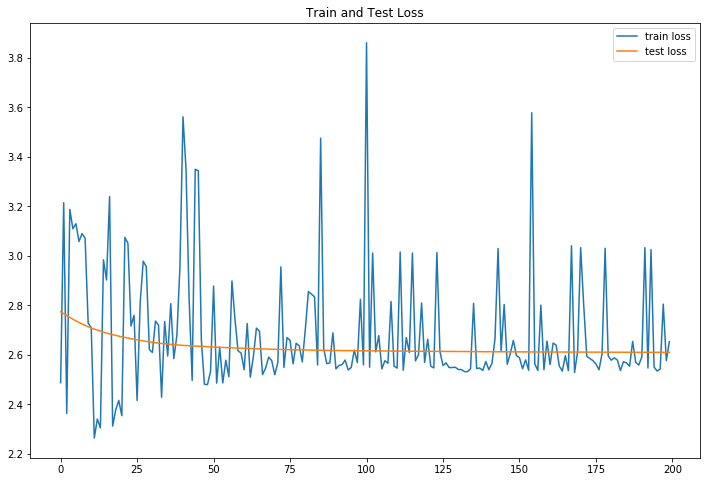

In [31]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

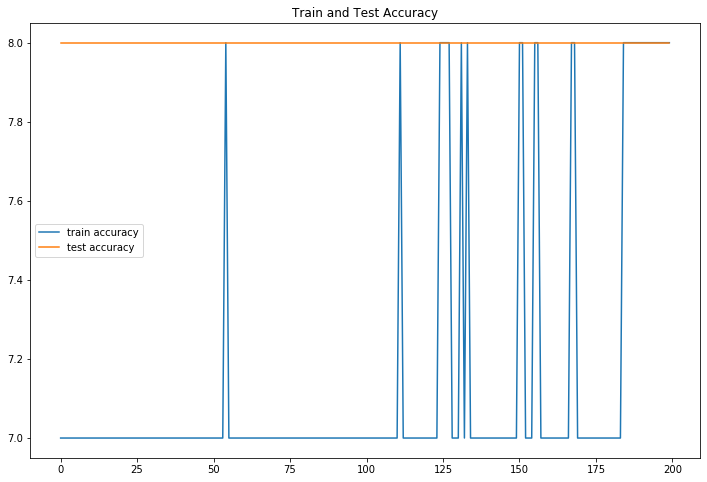

In [32]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show

In [122]:
#setting up dataframe for 2nd neural network (synthesis)
def create_move_df(song_id, filename):
    features = sp.audio_features(song_id)
    beats = get_beats(song_id, filename)
    song_features = features[0]
    analysis = sp.audio_analysis(song_id)
    sections = analysis['sections']
    curr_section_num = 0
    curr_section = sections[curr_section_num]

    #can add whatever features we feel like later, these ones felt like the most important for now
    cols = ["start_time", "duration", "section", "tempo", "danceability", "energy", "valence"]
    training_df_of_moves = pd.DataFrame(columns=cols)

    #add data to data frame (start, duration, section, tempo, features)
    for beat in beats[:-1]:
        #sets section number for current beat
        if (curr_section["start"] + curr_section["duration"]) < beat["start"]:
            if curr_section_num + 1 != len(sections):
                curr_section_num = curr_section_num + 1
            curr_section = sections[curr_section_num]
        
        #creating data in row format for df
        beat_data = [beat["start"], beat["duration"], curr_section_num, curr_section["tempo"], song_features["danceability"], song_features["energy"], song_features["valence"]]
        beat_line = pd.DataFrame([beat_data], columns=cols)
        training_df_of_moves = training_df_of_moves.append(beat_line)
    
    return training_df_of_moves

In [87]:
def get_beats(song_id, filename):
    analysis = sp.audio_analysis(song_id)
    #features = sp.audio_features(song_id)
    #Starting beat will change depending on song
    eight_counts = int(re.search("\d+.txt", filename).group()[0])
    beat_count = eight_counts * 8 #not sure if this should be 4 or eight, we will know when we can visualize
    beats = analysis['beats'][beat_count:]
    return beats


In [88]:
#setting up spotify credentials
def set_spotify():
    client_id = 'd0b2731526744c759fcf012a56ec5bd5'
    client_secret = '6e593cabd0e043da9041c5ef5825dec7'

    #Sets up authentication to use the Spotify API
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    #Creates a Spotipy session using the credentials
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    return sp

sp = set_spotify()
print("Spotify API Reached")

Spotify API Reached


In [114]:
cols = ["start_time", "duration", "section", "tempo", "danceability", "energy", "valence"]
training_df_of_moves = pd.DataFrame(columns=cols)
moves = create_move_df("1tNJrcVe6gwLEiZCtprs1u", "1tNJrcVe6gwLEiZCtprs1u_date2_7_3Nights_DominicFike_4.txt")
training_df_of_moves = pd.concat([training_df_of_moves, moves])
training_df_of_moves['index'] = range(0, len(training_df_of_moves))
training_df_of_moves = training_df_of_moves[['index', 'start_time', 'duration', 'section', 'tempo', 'danceability', 'energy', 'valence']]
input_song = training_df_of_moves.to_numpy().tolist()

In [120]:
output = NN(Variable(torch.FloatTensor(input_song)))
_, output_true = torch.max(output.data, 1)

In [121]:
output_true

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,